We have difficulty matching the reference frame of view 0 and view 1 camera of positrack. When the view goes from 0 to 1, there are large shifts in position in the path.

We don’t have the videos of both cameras at the same time, which would make matching easy.

But we have the arena_top.cropped video that should have a lot of data at the same time as view 0 and view 1. 

We could train a model that learns to transform position from view 1 to arena_top.cropped and then from arena_top.cropped back into view 0. 

view1 -> arena_top -> view0



In [1]:
%load_ext autoreload
%autoreload 2
%run setup_project.py
import os.path
from datetime import datetime, timezone
import shutil
import cv2
from autopipy.cvObjectDetectors import ArenaDetector
from autopipy.dlcObjectDetectors import MouseLEDsDetector


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


/home/kilo/repo/analysis_jingjie/jingjie/autopi_mec_jingjie/autopi_mec/mouse_and_objects_position_tracking/setup_project.py:769: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit()
/home/kilo/repo/analysis_jingjie/jingjie/autopi_mec_jingjie/autopi_mec/mouse_and_objects_position_tracking/setup_project.py:797: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit()


Loading DLC 2.2.3...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions= setup_project_session_lists()

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /adata/projects/autopi_mec
dlcModelPath: /adata/models
Reading /adata/projects/autopi_mec/sessionList_invalid
We have 1 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [3]:
def prepareSessionsForSpatialAnalysisProject(sSessions):
    print("Loading Animal_pose and Spike_train, sSes.ap and sSes.cg")
    for ses in tqdm(sSessions):
        ses.load_parameters_from_files() 
        ap = Animal_pose(ses)
        ses.ap = ap
        
prepareSessionsForSpatialAnalysisProject(sSessions)


Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|██████████| 1/1 [00:00<00:00, 839.87it/s]


Load spatial data

In [4]:
def correct_view_1_in_positrack_file(ses):
    # read arena top x and y data
    ext=".arena_top_cropped_mouseLEDs_offline_tracking.csv"
    fn = ses.fileBase+ext
    dfa = pd.read_csv(fn)

    #plt.plot(dfa.x,dfa.y)
    #plt.title("arena top")
    #plt.show()
    
    
    
    # read positrack2_post files
    for t in ses.trial_names:
        print(ses.path+"/"+t+".positrack2_post")
        df = pd.read_csv(ses.path+"/"+t+".positrack2_post")
        #plt.plot(df.x,df.y)
        #plt.title(ses.path+"/"+t+".positrack2_post")
        #plt.show()
    
        
    myList = [pd.read_csv(ses.path+"/"+t+".positrack2_post") for t in ses.trial_names]
    dfp = pd.concat(myList)

    
    
    ##################################################
    # first models to predict arena_top from view_1  #
    ##################################################
    # we need to linearly interpolate arena_top position to get the x and y at time when the view_id of positrack2 is 1
    fx = interp1d(dfa.time, dfa.x, bounds_error=False) # x we will start at 0 until the end of the file
    fy = interp1d(dfa.time, dfa.y, bounds_error=False) # y

    if np.sum(dfp.view_id==1) == 0:
        return 
    
    tp = dfp.acq_time_source_0[dfp.view_id==1]
    xp = dfp.x[dfp.view_id==1]
    yp = dfp.y[dfp.view_id==1]
    xa = fx(tp)
    ya = fy(tp)

    df = pd.DataFrame({"view1_x":xp,
                 "view1_y":yp,
                 "arena_x":xa,
                 "arena_y":ya})
    df = df.dropna(axis=0)
    
    print("model 1 data set shape:",df.shape)
    plt.scatter(df.view1_y,df.arena_y,s=1,alpha=0.2)
    plt.title("Compare arena view to positrack view y")
    plt.show()
    
    
    

    poly_features = PolynomialFeatures(degree=2,include_bias=False)
    train_set = df

    # train a model to predict the x coordinate in arena_top coordinate
    lin_reg_x_coord_1 = LinearRegression()
    X = train_set[["view1_x","view1_y"]].to_numpy()
    y = train_set["arena_x"].to_numpy()
    X_poly = poly_features.fit_transform(X)
    lin_reg_x_coord_1.fit(X_poly,y)
    y_pred_x_coord = lin_reg_x_coord_1.predict(X_poly)

    # train a model to predict the y coordinate in arena_top_coordinate
    lin_reg_y_coord_1 = LinearRegression()
    X = train_set[["view1_x","view1_y"]].to_numpy()
    y = train_set["arena_y"].to_numpy()
    X_poly = poly_features.fit_transform(X)
    lin_reg_y_coord_1.fit(X_poly,y)
    y_pred_y_coord = lin_reg_y_coord_1.predict(X_poly)

    plt.scatter(train_set.view1_y, y_pred_y_coord,s=1,alpha=0.2)
    plt.title("model 1 predictions y")
    plt.show()
    
    
    ######################################################
    # second models to predict view_id==0 from arena_top #
    ######################################################
    # we need to linearly interpolate positrack position to get the x and y at time when the view_id of positrack2 is 0
    indices = dfp.view_id==0
    fx = interp1d(dfp.acq_time_source_0[indices], dfp.x[indices], bounds_error=False) # x we will start at 0 until the end of the file
    fy = interp1d(dfp.acq_time_source_0[indices], dfp.y[indices], bounds_error=False) # y

    ta = dfa.time
    xa = dfa.x
    ya = dfa.y
    xp = fx(ta) # positract x position at time of dfa.x
    yp = fy(ta) # positract y position at time of dfa.y

    df = pd.DataFrame({"arena_x":xa,
                 "arena_y":ya,
                 "view0_x":xp,
                 "view0_y":yp})
    df = df.dropna(axis=0)

    plt.scatter(df.arena_y,df.view0_y,s=1,alpha=0.2)
    plt.title("Compare arena view to positrack view y")
    plt.show()
    
    
    print("model 2 data set shape:",df.shape)
    train_set = df

    # train a model to predict the x coordinate in arena_top coordinate
    lin_reg_x_coord_2 = LinearRegression()
    X = train_set[["arena_x","arena_y"]].to_numpy()
    y = train_set["view0_x"].to_numpy()
    X_poly = poly_features.fit_transform(X)
    lin_reg_x_coord_2.fit(X_poly,y)
    y_pred_x_coord = lin_reg_x_coord_2.predict(X_poly)

    # train a model to predict the y coordinate in arena_top_coordinate
    lin_reg_y_coord_2 = LinearRegression()
    X = train_set[["arena_x","arena_y"]].to_numpy()
    y = train_set["view0_y"].to_numpy()
    X_poly = poly_features.fit_transform(X)
    lin_reg_y_coord_2.fit(X_poly,y)
    y_pred_y_coord = lin_reg_y_coord_2.predict(X_poly)

    
    plt.scatter(train_set.arena_y, y_pred_y_coord,s=1,alpha=0.2)
    plt.title("model 2 predictions y")
    plt.show()
    
    
    ## we now have 4 models to go from viewId1 -> arena_top -> viewId0
    # lin_reg_x_coord_1
    # lin_reg_y_coord_1
    # lin_reg_x_coord_2
    # lin_reg_y_coord_2

    # correct positrack2_post files
    for pfn in [ses.path+"/"+t+".positrack2_post" for t in ses.trial_names]:
        print("correcting view1 x and y in",pfn)
        df = pd.read_csv(pfn)
        toReplace = (df.view_id==1)&(~df.x.isna())
        if np.sum(toReplace) > 0:
            #print(np.sum(toReplace))
            # from view1 to arena top
            X = df[["x","y"]][toReplace].to_numpy()
            X_poly = poly_features.fit_transform(X)
            x1 = lin_reg_x_coord_1.predict(X_poly)
            y1 = lin_reg_y_coord_1.predict(X_poly)
            # from arena top to view0
            X = np.stack([x1,y1]).T
            X_poly = poly_features.fit_transform(X)
            x2 = lin_reg_x_coord_2.predict(X_poly)
            y2 = lin_reg_y_coord_2.predict(X_poly)

            df.x[toReplace] = x2
            df.y[toReplace] = y2
            
            
            plt.plot(df.x,df.y)
            plt.title("after transformation")
            plt.show()
            
            
            
        df.to_csv(pfn,index=False)

In [5]:
ses = sSessions[0]

This function overwrite `positrack2_post` file.

/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_01.positrack2_post
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_02.positrack2_post
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_03.positrack2_post
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_04.positrack2_post
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_05.positrack2_post
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_06.positrack2_post
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_07.positrack2_post
model 1 data set shape: (1966, 4)


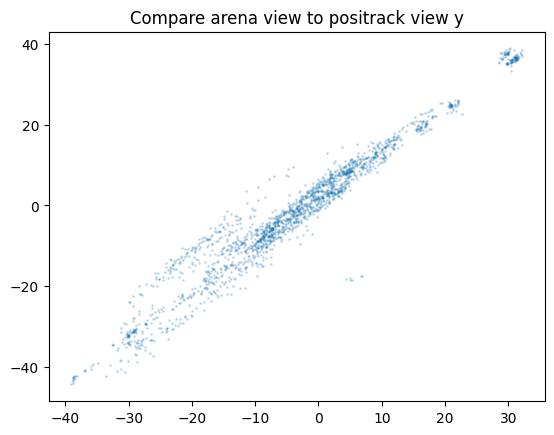

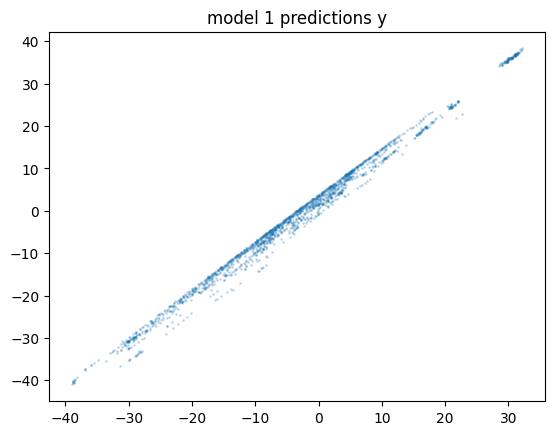

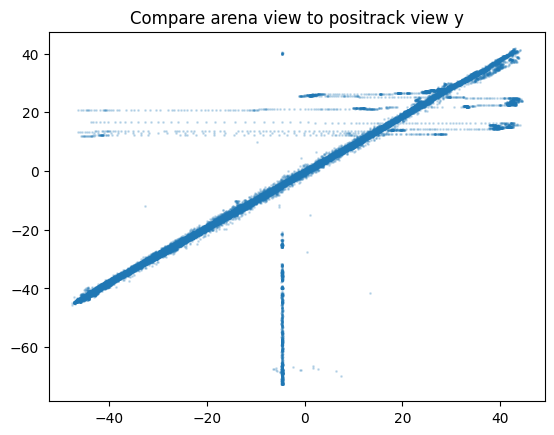

model 2 data set shape: (48843, 4)


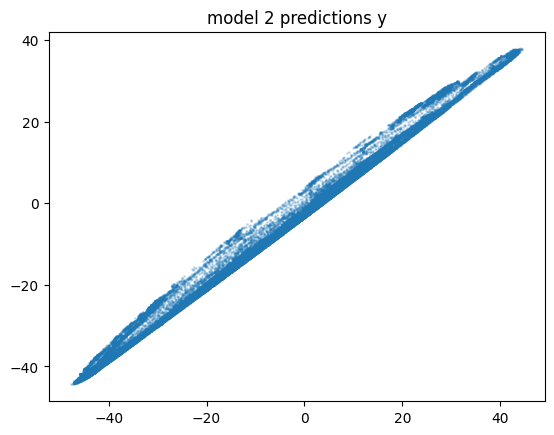

correcting view1 x and y in /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_01.positrack2_post


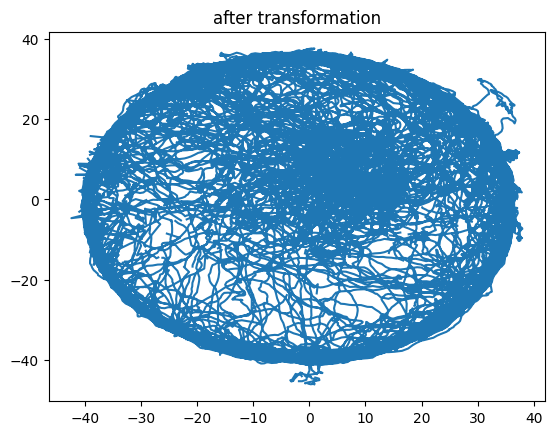

correcting view1 x and y in /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_02.positrack2_post


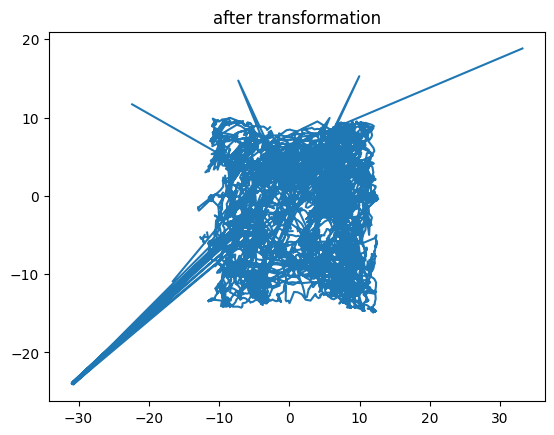

correcting view1 x and y in /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_03.positrack2_post


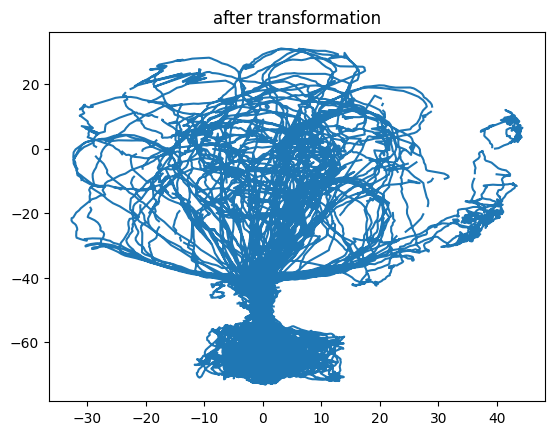

correcting view1 x and y in /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_04.positrack2_post


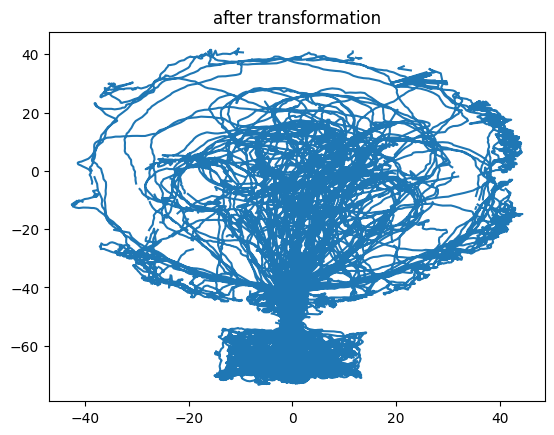

correcting view1 x and y in /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_05.positrack2_post


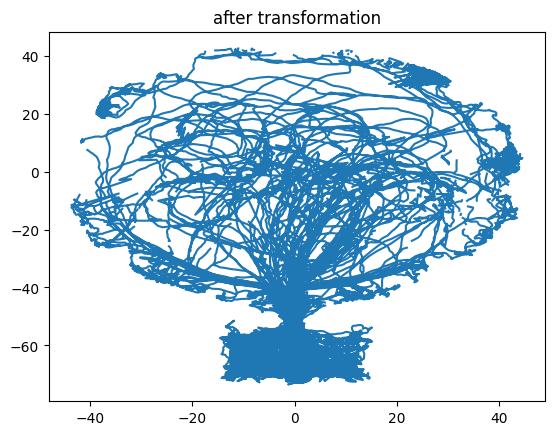

correcting view1 x and y in /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_06.positrack2_post


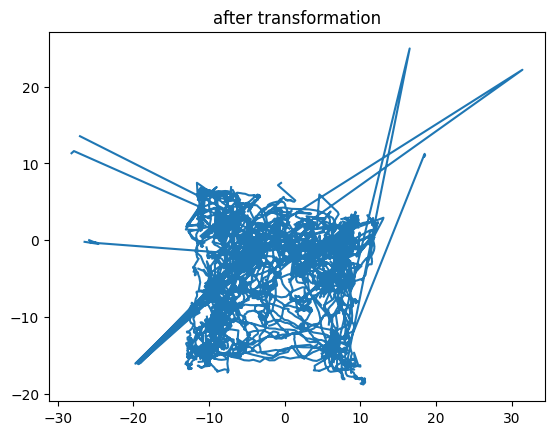

correcting view1 x and y in /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_07.positrack2_post


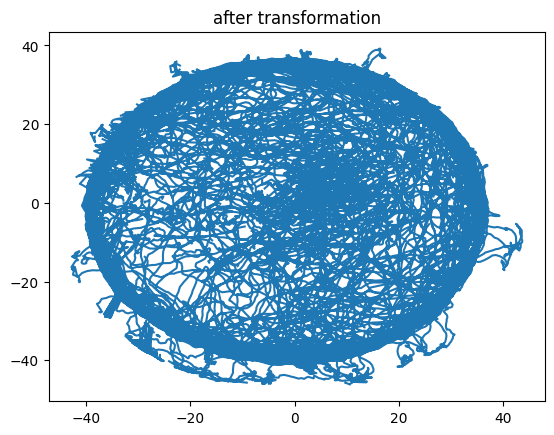

In [6]:
correct_view_1_in_positrack_file(ses)

0 mn8578-30112021-0107
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_01.positrack2_post
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_02.positrack2_post
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_03.positrack2_post
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_04.positrack2_post
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_05.positrack2_post
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_06.positrack2_post
/adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_07.positrack2_post
model 1 data set shape: (1966, 4)


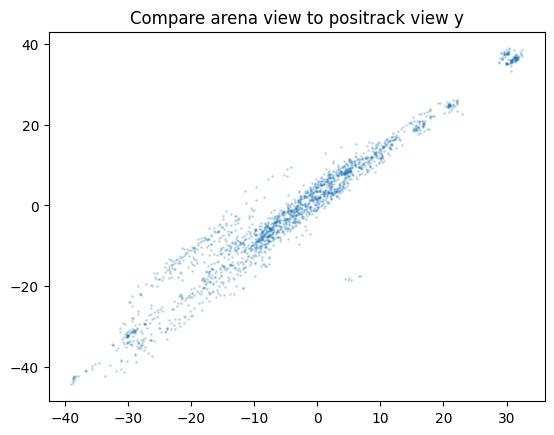

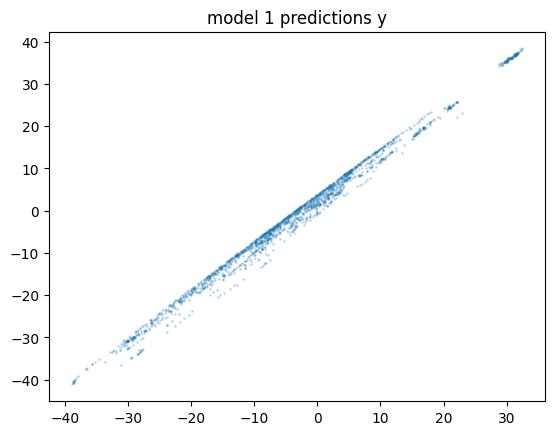

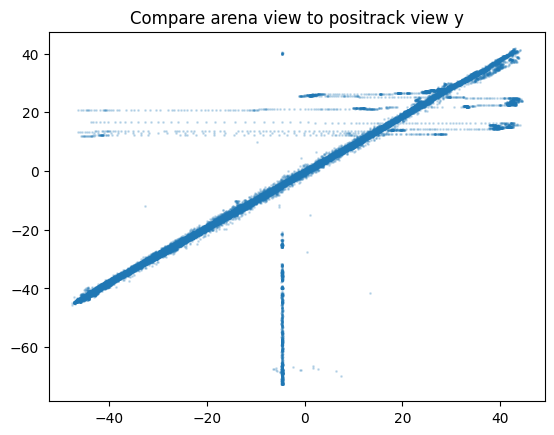

model 2 data set shape: (48843, 4)


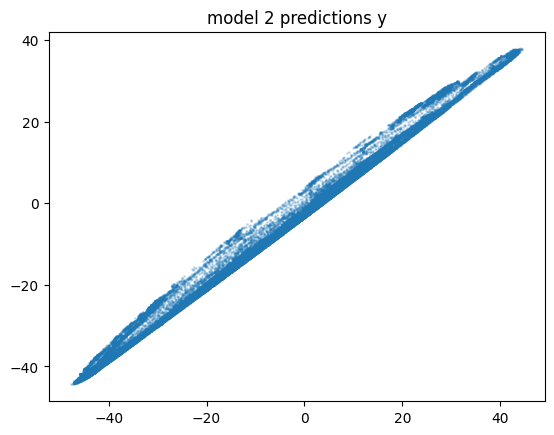

correcting view1 x and y in /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_01.positrack2_post


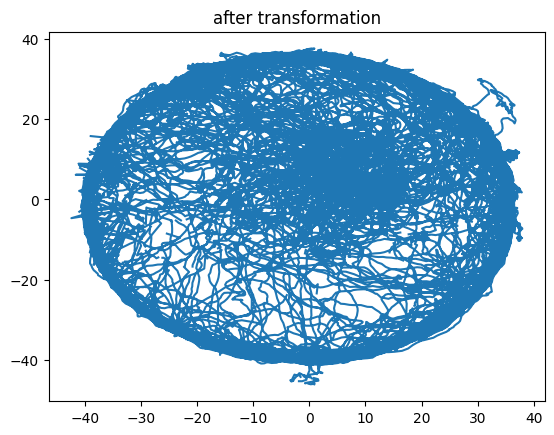

correcting view1 x and y in /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_02.positrack2_post


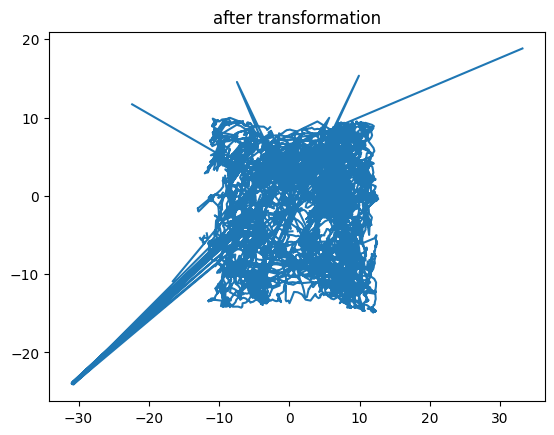

correcting view1 x and y in /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_03.positrack2_post


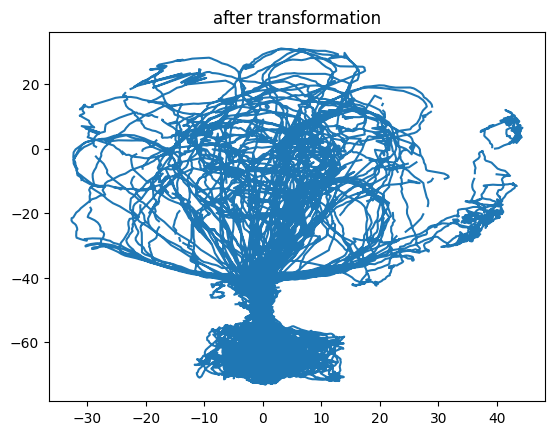

correcting view1 x and y in /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_04.positrack2_post


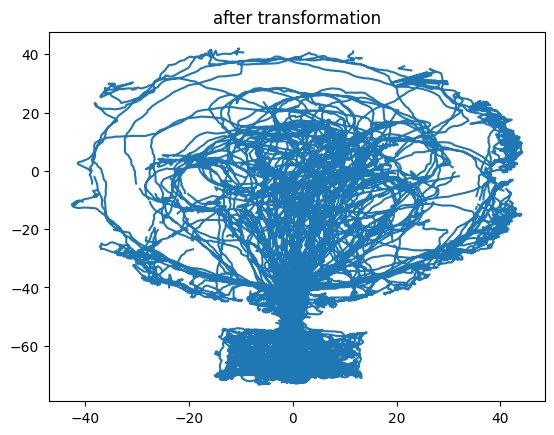

correcting view1 x and y in /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_05.positrack2_post


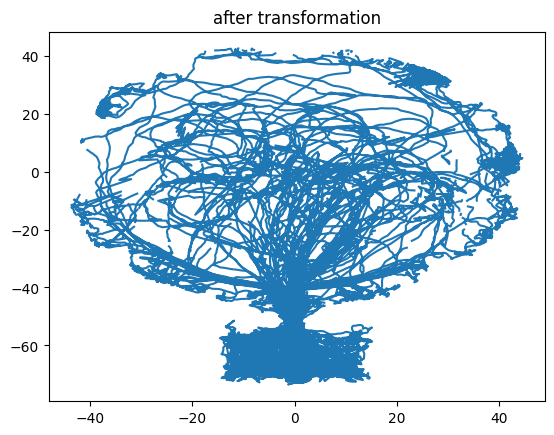

correcting view1 x and y in /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_06.positrack2_post


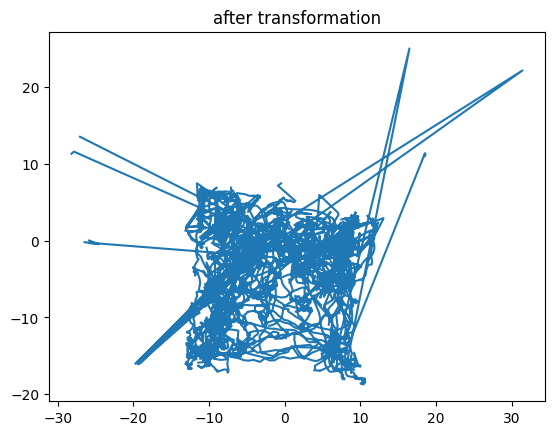

correcting view1 x and y in /adata/projects/autopi_mec/mn8578/mn8578-30112021-0107/mn8578-30112021_07.positrack2_post


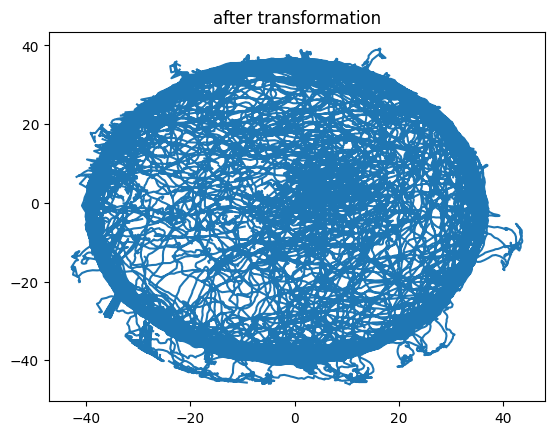

In [7]:
for i,ses in enumerate(sSessions):
    print(i,ses.name)
    correct_view_1_in_positrack_file(ses)